In [2]:
import tensorflow
tensorflow.version.VERSION


'1.14.0'

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50
# from tensorflow.keras.applications.resnet50 import ResNet50
import pydot
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Input, regularizers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# dataset source: https://www.kaggle.com/chetankv/dogs-cats-images   270 mb

In [2]:
test_dir="C:\\Users\\xiaoc\\Documents\\dog_vs_cat\\dataset\\test_set"
train_dir="C:\\Users\\xiaoc\\Documents\\dog_vs_cat\\dataset\\training_set"

train_dir_cats = train_dir + '\\cats'
train_dir_dogs = train_dir + '\\dogs'
test_dir_cats = test_dir + '\\cats'
test_dir_dogs = test_dir + '\\dogs'

In [3]:
print('No. of cats training images - ',len(os.listdir(train_dir_cats)))
print('No. of dogs training images - ',len(os.listdir(train_dir_dogs)))
print('No. of cats testing images - ',len(os.listdir(test_dir_cats)))
print('No of dogs testing images - ',len(os.listdir(test_dir_dogs)))

No. of cats training images -  4000
No. of dogs training images -  4000
No. of cats testing images -  1000
No of dogs testing images -  1000


In [4]:

def display_cat(name, number):


    tmp_dir = train_dir_cats + '\\' + name + '.' + str(number) + '.jpg'    
    img=cv2.imread(tmp_dir)
    plt.imshow(img)

def display_dog(name, number):


    tmp_dir = train_dir_dogs + '\\' + name + '.' + str(number) + '.jpg'    
    img=cv2.imread(tmp_dir)
    plt.imshow(img)
    

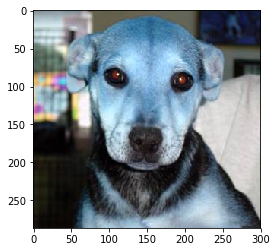

In [5]:
display_dog('dog',4)

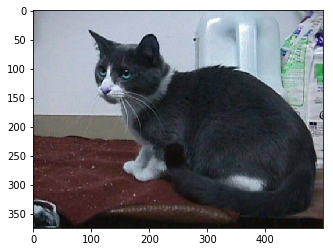

In [6]:
display_cat('cat',4)

In [7]:
train_data_generator = ImageDataGenerator(
#                                           rotation_range=90, 
#                                           zoom_range=0.2,
                                          rescale = 1.0/255) 

test_data_generator = ImageDataGenerator(rescale = 1.0/255) 

batch_size = 32

train_data = train_data_generator.flow_from_directory(directory = train_dir, 
                                                      target_size = (64, 64), 
                                                      batch_size = batch_size,
                                                      class_mode = 'binary')

test_data = test_data_generator.flow_from_directory(directory = test_dir, 
                                                    target_size = (64, 64), 
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
print(train_data.image_shape)
print(test_data.classes) 
print(len(test_data.classes))

(64, 64, 3)
[0 0 0 ... 1 1 1]
2000


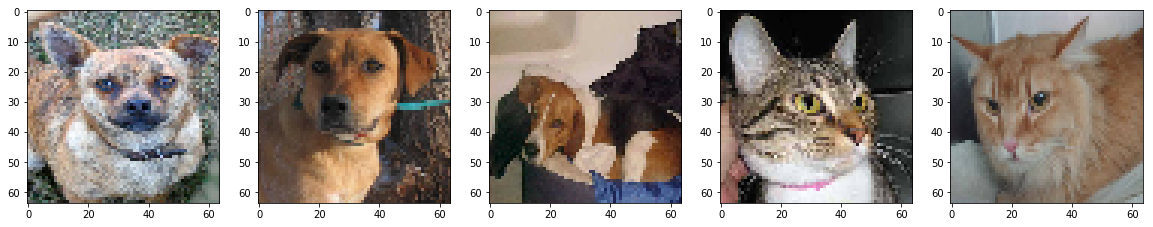

In [9]:
plt.figure(figsize = (20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_data[0][0][i])   #[250,1,32] [62,1,32]
plt.show()



In [ ]:
##############################################################################################
# ResNet50, MobileNet, VGG16
# simple CNN

In [6]:
def resnet():
    tf.keras.backend.set_learning_phase(0) #关闭BN
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=train_data.image_shape)
#     x = conv_base.output
    tf.keras.backend.set_learning_phase(1) #打开BN
#     for layer in conv_base.layers[:180]: #只训练自定义的全连接层
#         layer.trainable=False
#     for layer in conv_base.layers[180:]: #只训练自定义的全连接层
#         layer.trainable=True
    tmp_input = Input(train_data.image_shape)
    x = conv_base(tmp_input)
    x = AveragePooling2D()(x)
    x = Flatten()(x)
#     x = Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
#     x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x) 
    x = Dropout(0.5)(x)
#     x = Dense(64, activation='relu')(x) 
#     x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)  #输出[0.3,0.7]
#     model = Model(inputs=conv_base.input, outputs=x)
    model = Model(inputs=tmp_input, outputs=x)
#     for layer in conv_base.layers[:140]: #只训练自定义的全连接层
#         layer.trainable=False
#     for layer in conv_base.layers[140:]: #只训练自定义的全连接层
#         layer.trainable=True
    
    model.compile(optimizer = optimizers.Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    model.summary()
    
    return model

ResModel = resnet()

C:\Users\xiaoc\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________

In [7]:
# batch_zise = 32
# no_of_batch = 8000/32 = 250 

res_fitted_model = ResModel.fit_generator(train_data, 
                                          steps_per_epoch = 250,
                                          epochs = 50,
                                          validation_data = test_data,
                                          validation_steps = 64)

Epoch 1/50
250/250 [==============================] - 97s 388ms/step - loss: 0.9853 - acc: 0.6106 - val_loss: 0.6856 - val_acc: 0.7485
Epoch 2/50
250/250 [==============================] - 85s 340ms/step - loss: 0.6344 - acc: 0.7870 - val_loss: 0.5338 - val_acc: 0.8396
Epoch 3/50
250/250 [==============================] - 85s 341ms/step - loss: 0.5833 - acc: 0.7937 - val_loss: 0.5982 - val_acc: 0.7751
Epoch 4/50
250/250 [==============================] - 85s 340ms/step - loss: 0.5822 - acc: 0.7901 - val_loss: 0.5825 - val_acc: 0.7913
Epoch 5/50
250/250 [==============================] - 85s 341ms/step - loss: 0.5763 - acc: 0.7825 - val_loss: 0.6052 - val_acc: 0.7717
Epoch 6/50
250/250 [==============================] - 85s 341ms/step - loss: 0.6264 - acc: 0.7404 - val_loss: 0.6009 - val_acc: 0.7692
Epoch 7/50
250/250 [==============================] - 85s 341ms/step - loss: 0.5406 - acc: 0.7926 - val_loss: 0.5852 - val_acc: 0.7736
Epoch 8/50
250/250 [==============================] - 8

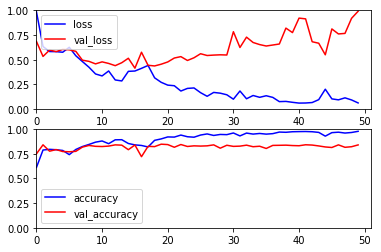

In [8]:
plt.figure()
ax1 = plt.subplot(211)
ax1.set_xlim([0, 51])
ax1.set_ylim([0, 1])
loss = res_fitted_model.history['loss']
val_loss = res_fitted_model.history['val_loss']
ax1.plot(range(len(loss)), loss, 'b', label = 'loss')
ax1.plot(range(len(loss)), val_loss, 'r', label = 'val_loss')
ax1.legend()

ax2 = plt.subplot(212)
ax2.set_xlim([0, 51])
ax2.set_ylim([0, 1])
accuracy = res_fitted_model.history['acc']
val_accuracy = res_fitted_model.history['val_acc']
ax2.plot(range(len(accuracy)), accuracy, 'b', label = 'accuracy')
ax2.plot(range(len(accuracy)), val_accuracy, 'r', label = 'val_accuracy')
ax2.legend()

# train_acc 97%   
# test_acc 83%

In [ ]:
########################################################

In [10]:
def vgg():

    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=train_data.image_shape)

    for layer in conv_base.layers: #只训练自定义的全连接层 效果较好   vgg没有用bn
        layer.trainable=False
#     conv_base.trainable = True  #如果训练了 卷积层 准确率就基本上不变50%左右
#     set_trainable = False
#     for layer in conv_base.layers:
#         if layer.name == 'block5_conv1':
#             set_trainable = True
#         if set_trainable:
#             layer.trainable = True
#         else:
#             layer.trainable = False

    x = conv_base.output
#     x = AveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
#     x = Dense(1024, activation='relu',  kernel_regularizer=regularizers.l2(0.0001))(x) 
#     x = Dropout(0.2)(x)
#     x = Dense(512, activation='relu',  kernel_regularizer=regularizers.l2(0.0001))(x) 
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x) 
    x = Dropout(0.3)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=conv_base.input, outputs=x)
#     model = Model(inputs=tmp_input, outputs=x)
    model.summary()    
    model.compile(optimizer = optimizers.Adam(learning_rate=0.00001), 
                  loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    
    return model

In [11]:
vgg_Model = vgg()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________

In [12]:
# batch_zise = 32
# no_of_batch = 8000/32 = 250 
fitted_model = vgg_Model.fit_generator(train_data,
                        steps_per_epoch = 250,
                        epochs = 50,
                        validation_data = test_data,
                        validation_steps = 64)

Epoch 1/50
250/250 [==============================] - 35s 138ms/step - loss: 0.7560 - acc: 0.5523 - val_loss: 0.5996 - val_acc: 0.6924
Epoch 2/50
250/250 [==============================] - 31s 124ms/step - loss: 0.6642 - acc: 0.6223 - val_loss: 0.5630 - val_acc: 0.7224
Epoch 3/50
250/250 [==============================] - 31s 125ms/step - loss: 0.6172 - acc: 0.6556 - val_loss: 0.5387 - val_acc: 0.7461
Epoch 4/50
250/250 [==============================] - 31s 125ms/step - loss: 0.5869 - acc: 0.6823 - val_loss: 0.5139 - val_acc: 0.7598
Epoch 5/50
250/250 [==============================] - 32s 126ms/step - loss: 0.5625 - acc: 0.7103 - val_loss: 0.4969 - val_acc: 0.7687
Epoch 6/50
250/250 [==============================] - 32s 129ms/step - loss: 0.5501 - acc: 0.7163 - val_loss: 0.4853 - val_acc: 0.7697
Epoch 7/50
250/250 [==============================] - 31s 125ms/step - loss: 0.5362 - acc: 0.7300 - val_loss: 0.4763 - val_acc: 0.7746
Epoch 8/50
250/250 [==============================] - 3

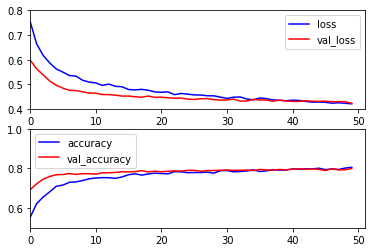

In [13]:
plt.figure()
ax1 = plt.subplot(211)
ax1.set_xlim([0, 51])
ax1.set_ylim([0.4, 0.8])
loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
ax1.plot(range(len(loss)), loss, 'b', label = 'loss')
ax1.plot(range(len(loss)), val_loss, 'r', label = 'val_loss')
ax1.legend()

ax2 = plt.subplot(212)
ax2.set_xlim([0, 51])
ax2.set_ylim([0.5, 1])
accuracy = fitted_model.history['acc']
val_accuracy = fitted_model.history['val_acc']
ax2.plot(range(len(accuracy)), accuracy, 'b', label = 'accuracy')
ax2.plot(range(len(accuracy)), val_accuracy, 'r', label = 'val_accuracy')
ax2.legend()

In [37]:
def testing_image(image_directory): 
    test_image = image.load_img(image_directory, target_size = (64, 64))
#     img=cv2.imread(test_image)
#     plt.imshow(img)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)  #需要加以维度才可以满足输入尺寸
    result = vgg_Model.predict(x = test_image)
    print(result)

    if result[0][0]  == 1:
        prediction = 'Dog'
    else:
        prediction = 'Cat'
    return prediction

print(testing_image(test_dir + '\\dogs\\dog.4044.jpg' ))
print(testing_image(test_dir + '\\cats\\cat.4004.jpg' ))

[[1.00000000e+00 1.10499944e-32]]
Dog
[[1.1336484e-06 9.9999881e-01]]
Cat


In [ ]:
########################################################3

In [10]:
def mobile_net():
    conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=train_data.image_shape)

    for layer in conv_base.layers:
        layer.trainable=False

    x = conv_base.output
    x = Flatten()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dense(1024, activation='relu',  kernel_regularizer=regularizers.l2(0.0001))(x) 
    x = Dropout(0.2)(x)
#     x = Dense(512, activation='relu',  kernel_regularizer=regularizers.l2(0.0001))(x) 
#     x = Dropout(0.15)(x)
#     x = Dense(64, activation='relu')(x) 
#     x = Dropout(0.15)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=conv_base.input, outputs=x)
    model.summary()    
    model.compile(optimizer = optimizers.Adam(learning_rate=0.00005), 
                  loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    
    return model

In [11]:
mb_Model = mobile_net()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\xiaoc\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128   

In [12]:
# batch_zise = 32
# no_of_batch = 8000/32 = 250 
fitted_model = mb_Model.fit_generator(train_data,
                        steps_per_epoch = 250,
                        epochs = 50,
                        validation_data = test_data,
                        validation_steps = 64)

Epoch 1/50
250/250 [==============================] - 23s 92ms/step - loss: 1.1961 - acc: 0.5792 - val_loss: 0.7949 - val_acc: 0.6727
Epoch 2/50
250/250 [==============================] - 23s 92ms/step - loss: 0.9405 - acc: 0.6535 - val_loss: 0.6377 - val_acc: 0.7279
Epoch 3/50
250/250 [==============================] - 23s 92ms/step - loss: 0.8074 - acc: 0.6902 - val_loss: 0.6077 - val_acc: 0.7451
Epoch 4/50
250/250 [==============================] - 23s 93ms/step - loss: 0.7510 - acc: 0.7129 - val_loss: 0.5593 - val_acc: 0.7692
Epoch 5/50
250/250 [==============================] - 23s 93ms/step - loss: 0.7333 - acc: 0.7241 - val_loss: 0.5373 - val_acc: 0.7790
Epoch 6/50
250/250 [==============================] - 25s 98ms/step - loss: 0.6847 - acc: 0.7361 - val_loss: 0.5473 - val_acc: 0.7790
Epoch 7/50
250/250 [==============================] - 24s 94ms/step - loss: 0.6700 - acc: 0.7375 - val_loss: 0.5607 - val_acc: 0.7781
Epoch 8/50
250/250 [==============================] - 23s 93ms

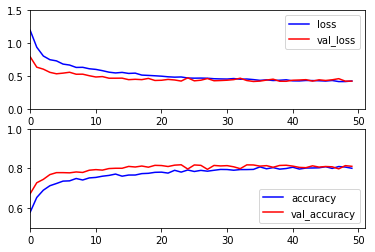

In [13]:
plt.figure()
ax1 = plt.subplot(211)
ax1.set_xlim([0, 51])
ax1.set_ylim([0, 1.5])
loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
ax1.plot(range(len(loss)), loss, 'b', label = 'loss')
ax1.plot(range(len(loss)), val_loss, 'r', label = 'val_loss')
ax1.legend()

ax2 = plt.subplot(212)
ax2.set_xlim([0, 51])
ax2.set_ylim([0.5, 1])
accuracy = fitted_model.history['acc']
val_accuracy = fitted_model.history['val_acc']
ax2.plot(range(len(accuracy)), accuracy, 'b', label = 'accuracy')
ax2.plot(range(len(accuracy)), val_accuracy, 'r', label = 'val_accuracy')
ax2.legend()

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [6]:
# 结果比较好的 
def plain_CNN():
    
    initial_input = Input(train_data.image_shape)
    x = Conv2D(32, kernel_size = (3, 3), activation='relu')(initial_input)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

#     x = Conv2D(64, kernel_size = (3, 3), activation='relu')(x)
    x = Conv2D(64, kernel_size = (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)
#     x = Conv2D(128, kernel_size = (3, 3), activation = 'relu')(x)
    x = Conv2D(128, kernel_size = (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)
#     model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu'))
#     model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))
    x = Flatten()(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.15)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.15)(x)
#     x = Dense(32, activation = 'relu')(x)
#     x = Dropout(0.1)(x)
    x = Dense(2, activation = 'softmax')(x)
    
    model = Model(inputs=initial_input, outputs=x)
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
#     plot_model(model, to_file='C:\\Users\\xiaoc\\Documents\\dog_vs_cat\\resnet.png', show_shapes=True, show_layer_names=True)
    
    return model

In [7]:
Model = plain_CNN()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________

In [8]:
# # good simple CNN result   functional 
# # batch_zise = 32
# # no_of_batch = 8000/32 = 250 
fitted_model = Model.fit_generator(train_data,
                        steps_per_epoch = 250,
                        epochs = 50,
                        validation_data = test_data,
                        validation_steps = 64)

Epoch 1/50
250/250 [==============================] - 21s 85ms/step - loss: 0.6919 - acc: 0.5179 - val_loss: 0.6702 - val_acc: 0.6240
Epoch 2/50
250/250 [==============================] - 22s 86ms/step - loss: 0.6867 - acc: 0.5259 - val_loss: 0.6698 - val_acc: 0.5974
Epoch 3/50
250/250 [==============================] - 22s 87ms/step - loss: 0.6615 - acc: 0.5930 - val_loss: 0.6312 - val_acc: 0.6683
Epoch 4/50
250/250 [==============================] - 22s 87ms/step - loss: 0.6168 - acc: 0.6580 - val_loss: 0.5927 - val_acc: 0.6880
Epoch 5/50
250/250 [==============================] - 22s 87ms/step - loss: 0.5965 - acc: 0.6761 - val_loss: 0.5826 - val_acc: 0.7092
Epoch 6/50
250/250 [==============================] - 22s 87ms/step - loss: 0.5693 - acc: 0.7080 - val_loss: 0.6253 - val_acc: 0.6865
Epoch 7/50
250/250 [==============================] - 22s 86ms/step - loss: 0.5431 - acc: 0.7280 - val_loss: 0.5083 - val_acc: 0.7549
Epoch 8/50
250/250 [==============================] - 22s 87ms

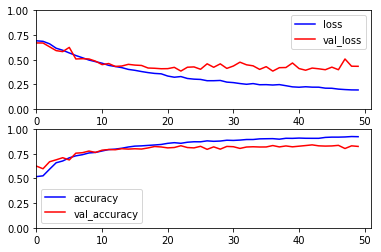

In [11]:
plt.figure()
ax1 = plt.subplot(211)
ax1.set_xlim([0, 51])
ax1.set_ylim([0, 1])
loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
ax1.plot(range(len(loss)), loss, 'b', label = 'loss')
ax1.plot(range(len(loss)), val_loss, 'r', label = 'val_loss')
ax1.legend()

ax2 = plt.subplot(212)
ax2.set_xlim([0, 51])
ax2.set_ylim([0, 1])
accuracy = fitted_model.history['acc']
val_accuracy = fitted_model.history['val_acc']
ax2.plot(range(len(accuracy)), accuracy, 'b', label = 'accuracy')
ax2.plot(range(len(accuracy)), val_accuracy, 'r', label = 'val_accuracy')
ax2.legend()

In [ ]:
###############################################################################

Populating the interactive namespace from numpy and matplotlib


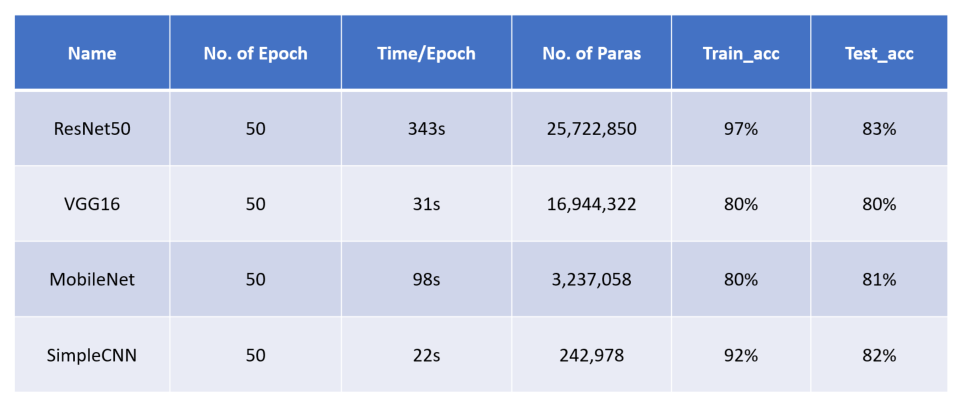

In [20]:
%pylab inline
from IPython.display import Image
Image(tmp_dir)